### Nonlinear Problems in Finance (MATHGR5400), Columbia University, Spring 2019
# Homework IV

### Due Date: 11:55 PM Thursday, May 2, 2019
You should turn in the notebook at Columbia CourseWorks website

Please comment your code properly.

Before you turn in the notebook, press the "Run all cells" button in the toolbar, and make sure all the calculation results and graphs are produced correctly in a reasonable time frame, and then save the notebook.

<h3 style="color:deepskyblue">Uncertain Volatility Model 1D</h3>

The price of a vanilla payoff $g(X_T)$ on a single asset $X_t$ in the uncertain volatility model satisfies the
one dimensional Black-Scholes-Barenblatt (BSB) PDE
\begin{align*}
\partial_tu(t,x)+\frac{1}{2}x^2\partial_x^2u(t,x)\Sigma\left(\partial_x^2u(t,x)\right)^2&=0\\
u(T,x)&=g(x)
\end{align*}
where
\begin{equation*}
\Sigma(\Gamma)=\left\{\begin{array}\,
\underline{\sigma} & \text{ if }\Gamma<0\\ \overline{\sigma} & \text{ if }\Gamma\geq 0\end{array}\right.
\end{equation*}
For the sake of simplicity, we assume zero interest rate and zero dividend and repo.

The BSB PDE is a fully nonlinear second order parabolic PDE which has a stochastic representation by second-oder BSDE. We are free to choose the diffusion for $X$; we pick a lognormal dynamics with some constant volatility $\hat\sigma$,

$$dX_t=\hat{\sigma} X_tdW_t$$

Two numerical schemes to solve 2-BSDEs are presented below. We first divide $(0, T)$ into $n$ subintervals $(t_{i-1}, t_i)$, $1\leq i\leq n$ and set $\Delta t_i=t_i-t_{i-1}$ and $\Delta W_{t_i} = W_{t_i} - W_{t_{i-1}}$.

<b>Scheme 1</b>
\begin{align*}
Y_{t_n}&=g(X_{t_n})\\
Z_{t_n}&=g'\left(X_{t_n}\right)\\
Y_{t_{i-1}}&=\mathbb{E}_{i-1}\left[Y_{t_i}\right]+\frac{1}{2}\Gamma_{t_{i-1}}X_{t_{i-1}}^2\left(\Sigma\left(\Gamma_{t_{i-1}}\right)^2-\hat{\sigma}^2\right)\Delta t_i\\
Z_{t_{i-1}}&=\frac{1}{\Delta t_i\hat{\sigma} X_{t_{i-1}}}\mathbb{E}_{i-1}\left[Y_{t_i}\Delta W_{t_i}\right]\\
\Gamma_{t_{i-1}}&=\frac{1}{\Delta t_i\hat{\sigma} X_{t_{i-1}}}\mathbb{E}_{i-1}\left[Z_{t_i}\Delta W_{t_i}\right]
\end{align*}

In the second scheme, we introduce explicitly the Malliavin weight for the log-normal diffusion with volatility $\hat{\sigma}$, so that $\Gamma$ can be estimated directly from $Y$ without computing $Z$ in the intermediate step. In particular, there is no need to compute the final condition $Z_{t_n}=g'\left(X_{t_n}\right)$. This could be useful to handle non-smooth payoffs.

<b>Scheme 2</b>
\begin{align*}
Y_{t_n}&=g(X_{t_n})\\
Y_{t_{i-1}}&=\mathbb{E}_{i-1}\left[Y_{t_i}\right]+\frac{1}{2}\Gamma_{t_{i-1}}X_{t_{i-1}}^2\left(\Sigma\left(\Gamma_{t_{i-1}}\right)^2-\hat{\sigma}^2\right)\Delta t_i\\
\Gamma_{t_{i-1}}&=\frac{1}{\left(\Delta t_i\hat{\sigma} X_{t_{i-1}}\right)^2}\mathbb{E}_{i-1}\left[Y_{t_i}\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right]
\end{align*}

In [6]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

In [12]:
def piecewiselinear_fit(xdata, ydata, knots):
    """
    Parameters
    ----------
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points.
    knots: array_like
        Knots of the piecewise linear function, must be increasing.
    
    Returns
    -------
    res: ndarray
        Coefficients of the piecewise linear function
    """
    nknots = len(knots)
    diag = np.identity(nknots)
    A = np.vstack([np.interp(xdata, knots, diag[i]) for i in range(nknots)]).T
    return np.linalg.lstsq(A, ydata)[0]

<b style="color:darkorange">Question 1.</b> Consider pricing the call spread $\frac{100}{K_2-K_1}\left(\left(X_T-K_1\right)^+-\left(X_T-K_2\right)^+\right)$ in the uncertain volatility model, where

\begin{equation*}
\underline{\sigma}=0.1,\quad\overline{\sigma}=0.2,\quad X_0=100,\quad T=1, \quad K_1 = 90, \quad K_2 = 110
\end{equation*}

For your reference, the true price (from PDE) is $56.0$.

<b>(a).</b> An implementation of Scheme 1 outlined above is provided for your convenience.

<ul>
<li> Experiment with different values of $\hat\sigma$, $\Delta t$, and number of paths. Comment on the results.
<li> Describe the region where the gamma is positive (resp. negative).
</ul>

<b>(b).</b> Implement Scheme 2 outlined above to price the call spread. As in part (a), after you obtain estimates of $x\mapsto\Gamma\left(t_i, x\right)$ at each discretization time $t_i$, re-simulate a new set of independent paths following the process $dX_t = \Sigma(\Gamma(t,X_t))X_tdW_t$ to price the call spread, using more time steps. Compare the results of the two schemes.


<b>(c).</b> In schemes 1 and 2, the estimations of the conditional expectations for $Z_{t_{i-1}}$ and $\Gamma_{t_{i-1}}$ may suffer large variances when $\Delta t_i$ is small. Control variates can be used to reduce the variance. For example, Scheme 2 can be modified as follows

<b>Scheme 2a</b>
\begin{align*}
Y_{t_n}&=g(X_{t_n})\\
Y_{t_{i-1}}&=\mathbb{E}_{i-1}\left[Y_{t_i}\right]+\frac{1}{2}\Gamma_{t_{i-1}}X_{t_{i-1}}^2\left(\Sigma\left(\Gamma_{t_{i-1}}\right)^2-\hat{\sigma}^2\right)\Delta t_i\\
\Gamma_{t_{i-1}}&=\frac{1}{\left(\Delta t_i\hat{\sigma} X_{t_{i-1}}\right)^2}\mathbb{E}_{i-1}\left[\left(Y_{t_i}-\mathbb{E}_{i-1}\left[Y_{t_i}\right]\right)\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right]
\end{align*}
Note that $Y_{t_i}$ on the right side of the last equation has been replaced by $Y_{t_{i}}-\mathbb{E}_{i-1}\left[Y_{t_i}\right]$.

Explain why this replacement does not change the left hand side. Implement Scheme 2a. Do you observe variance reduction?

For a justification of Scheme 2a, see the forthcoming written homework.

In [13]:
T = 1
X0 = 100
KL = 90
KH = 110
volL = 0.1
volH = 0.2
c = 100./(KH-KL)

def g(x):
    return c*(np.maximum(x-KL, 0)-np.maximum(x-KH, 0))

def Dg(x):
    return c*np.asfarray((x >= KL) & (x <= KH))

def Sigma(x):
    return np.where(x >= 0, volH, volL)

In [14]:
# # # Backward induction to compute Sigma # # #
nsteps = 12
ts = np.linspace(0, T, nsteps+1)
nknots = 15
vol = 0.2
npaths = 5000
dW = np.vstack((np.zeros((1, npaths), dtype=np.float),
                np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts))[:, np.newaxis]))
#W stores the brownian increments. The ith index is the increment from time t_{i-1} to t_i
#so W[0,:] = 0, and isn't an actual increment
W = np.cumsum(dW, axis=0)
X = np.exp(-0.5*vol**2*ts[:, np.newaxis] + vol*W)*X0


xps = np.full((len(ts), nknots), np.nan, dtype=np.float)
gps = np.full((len(ts), nknots), np.nan, dtype=np.float)

Y = g(X[-1])
Z = Dg(X[-1])

for i in range(len(ts)-2, 0, -1):
    dt = ts[i+1] - ts[i]
    #store the knot locations for the ith time at the ith index
    xps[i] = np.linspace(np.percentile(X[i], 1), np.percentile(X[i], 99), nknots)
    #predict t_{i+1}'s Y value using time t_i's X value
    yE = np.interp(X[i], xps[i], piecewiselinear_fit(X[i], Y, xps[i]))
    #store predictor of gamma at time t_i 
    gps[i] = piecewiselinear_fit(X[i], Z*dW[i+1]/(dt*vol*X[i]), xps[i])
    #calculate the gamma using regression
    G = np.interp(X[i], xps[i], gps[i])
    #calculate the delta using regression
    Z = np.interp(X[i], xps[i], piecewiselinear_fit(X[i], Y*dW[i+1]/(dt*vol*X[i]), xps[i]))
    #calculate t_i's Y value and store it in the vector
    Y = yE + dt/2*X[i]**2*G*(Sigma(G)**2-vol**2)

dt = ts[1]-ts[0]
# in the last step of backward induction, the conditional expectations reduce to the mean values 
G = np.mean(Z*dW[1]/(dt*vol*X0))
volp = Sigma(G)

# # # independent simulation to get a lower bound price # # #

npaths = 2**15
# we use more discretization time steps in this second run to simulate accurately the (nearly) optimal X process
nsteps = 400
Dt = ts[1]-ts[0]
ts_ = np.linspace(0, T, nsteps+1)
dW = np.vstack((np.zeros((1, npaths), dtype=np.float),
                np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts_))[:, np.newaxis]))
X = np.full((len(ts_), npaths), np.nan, dtype=np.float)
X[0] = X0

#calculating for all the times that will use the last step vol
m = int(round(ts[1]/(ts_[1]-ts_[0])))
#goes up to m, so X[m] is known at the end of the for loop
for i in range(1, m+1):
    dt = ts_[i] - ts_[i-1]
    X[i] = X[i-1]*np.exp(-0.5*volp**2*dt+dW[i]*volp)

#go through rest of the indices normally    
for i in range(m+1, len(ts_)):
    dt = ts_[i] - ts_[i-1]
    #determine under which gamma regression function the current time step should go
    #since we are beginning at m+1 no matter what, the value of j before minusing 1 will be ceil(>)
    j = int(np.ceil(ts_[i]/Dt))-1
    #estimate the optimal vol for the increment i-1 to i using time i-1's state variable and gamma regression 
    vols = Sigma(np.interp(X[i-1], xps[j], gps[j]))
    #calculate the actual X value at time i using the optimal vol
    X[i] = X[i-1]*np.exp(-0.5*vols**2*dt+dW[i]*vols)

#print(np.mean(g(X[-1])))

#### Q1a.)

In [15]:
def Scheme1(volbs, steps, paths):
    nsteps = steps
    ts = np.linspace(0, T, nsteps+1)
    nknots = 15
    vol = volbs
    npaths = paths
    dW = np.vstack((np.zeros((1, npaths), dtype=np.float),
                    np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts))[:, np.newaxis]))
    #W stores the brownian increments. The ith index is the increment from time t_{i-1} to t_i
    #so W[0,:] = 0, and isn't an actual increment
    W = np.cumsum(dW, axis=0)
    X = np.exp(-0.5*vol**2*ts[:, np.newaxis] + vol*W)*X0


    xps = np.full((len(ts), nknots), np.nan, dtype=np.float)
    gps = np.full((len(ts), nknots), np.nan, dtype=np.float)

    Y = g(X[-1])
    Z = Dg(X[-1])

    for i in range(len(ts)-2, 0, -1):
        dt = ts[i+1] - ts[i]
        #store the knot locations for the ith time at the ith index
        xps[i] = np.linspace(np.percentile(X[i], 1), np.percentile(X[i], 99), nknots)
        #predict t_{i+1}'s Y value using time t_i's X value
        yE = np.interp(X[i], xps[i], piecewiselinear_fit(X[i], Y, xps[i]))
        #store predictor of gamma at time t_i 
        gps[i] = piecewiselinear_fit(X[i], Z*dW[i+1]/(dt*vol*X[i]), xps[i])
        #calculate the gamma using regression
        G = np.interp(X[i], xps[i], gps[i])
        #calculate the delta using regression
        Z = np.interp(X[i], xps[i], piecewiselinear_fit(X[i], Y*dW[i+1]/(dt*vol*X[i]), xps[i]))
        #calculate t_i's Y value and store it in the vector
        Y = yE + dt/2*X[i]**2*G*(Sigma(G)**2-vol**2)

    dt = ts[1]-ts[0]
    # in the last step of backward induction, the conditional expectations reduce to the mean values 
    G = np.mean(Z*dW[1]/(dt*vol*X0))
    volp = Sigma(G)

    # # # independent simulation to get a lower bound price # # #

    npaths = 2**15
    # we use more discretization time steps in this second run to simulate accurately the (nearly) optimal X process
    nsteps = 400
    Dt = ts[1]-ts[0]
    ts_ = np.linspace(0, T, nsteps+1)
    dW = np.vstack((np.zeros((1, npaths), dtype=np.float),
                    np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts_))[:, np.newaxis]))
    X = np.full((len(ts_), npaths), np.nan, dtype=np.float)
    X[0] = X0

    #calculating for all the times that will use the last step vol
    m = int(round(ts[1]/(ts_[1]-ts_[0])))
    #goes up to m, so X[m] is known at the end of the for loop
    for i in range(1, m+1):
        dt = ts_[i] - ts_[i-1]
        X[i] = X[i-1]*np.exp(-0.5*volp**2*dt+dW[i]*volp)

    #go through rest of the indices normally    
    for i in range(m+1, len(ts_)):
        dt = ts_[i] - ts_[i-1]
        #determine under which gamma regression function the current time step should go
        #since we are beginning at m+1 no matter what, the value of j before minusing 1 will be ceil(>)
        j = int(np.ceil(ts_[i]/Dt))-1
        #estimate the optimal vol for the increment i-1 to i using time i-1's state variable and gamma regression 
        vols = Sigma(np.interp(X[i-1], xps[j], gps[j]))
        #calculate the actual X value at time i using the optimal vol
        X[i] = X[i-1]*np.exp(-0.5*vols**2*dt+dW[i]*vols)

    return(np.mean(g(X[-1])))

In [16]:
print("Scheme 1 Price = {}".format(Scheme1(.2,12,5000)))

Scheme 1 Price = 55.04417275669754


In [17]:
xvals = np.linspace(85, 125)
G_ = np.full((len(ts), len(xvals)), np.nan, dtype = np.float)
for i in range(len(ts)-2, 0, -1):
    G_[i] = np.interp(xvals, xps[i], gps[i])

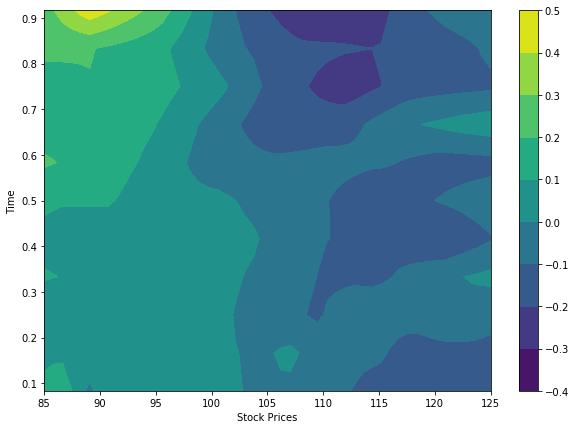

In [18]:
plt.figure(figsize = (10,7))
B,D = np.meshgrid( xvals,ts[1:len(ts)-1])
plt.contourf(B,D, G_[1:len(ts)-1])
plt.colorbar()
plt.xlabel('Stock Prices')
plt.ylabel('Time')
plt.show()

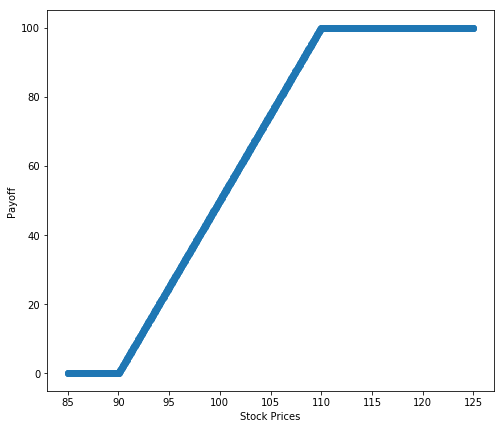

In [19]:
plt.figure(figsize = (8,7))
xcor = np.linspace(85, 125, 1000)
ycor = g(xcor)
plt.xlabel('Stock Prices')
plt.ylabel('Payoff')
plt.scatter(xcor,ycor)

- From the above two figures, we see that the Gamma does not typically change in sign over time for a given stock price. So for very ITM prices, the Gamma stayed negative regardless of the time to expiry, and for very OTM prices the Gamma typically stayed positive. This was a relatively consistent trend, that for higher stock prices the gamma was more and more negative, while for lower stock prices the gamma was positive. This makes sense since for OTM prices, as stock price increases the rate at which the option value will increase with respect to stock price also increases (approaching the sloped positive payoff region). And for already ITM prices, the rate at which the option value increases (for increases in stock price) decreases since the payoff is constant at $100\text{USD}$. We also see that gamma peaks in absolute value close to maturity (since the option value very closely mimics the payoff so close to expiration), at the $90$ and $110$ dollar regions, the two spots on the payoff diagram where increases in stock price would lead to either a large jump in the rate of change of option price with respect to stock price, or a large drop, respectively. 

- The region for which the sign of gamma changed over time was surrounding the $100\text{USD}$ mark, which was also the region that at maturity would lead to a payoff of exactly half the range of the payoff and was in the middle of the sloped payoff region. The gamma switched signs but was still typically close to $0$. This made sense since at this region of the payoff diagram, increases in stock price would not lead to much of a change in the rate at which value was changing.

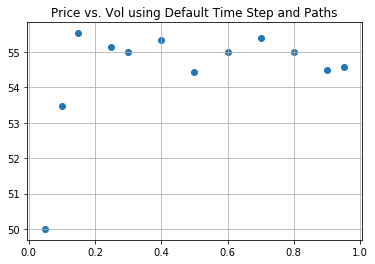

In [20]:
volvals = []
for vol in [.05, .1, .15, .25, .3, .4, .5,.6, .7, .8,.9,.95]:
    volvals.append(Scheme1(vol, 12, 5000))
    
fig, ax = plt.subplots()
ax.scatter([.05, .1, .15, .25, .3, .4, .5,.6, .7, .8,.9,.95], volvals, alpha=1)
ax.set_title("Price vs. Vol using Default Time Step and Paths")
ax.grid(True)

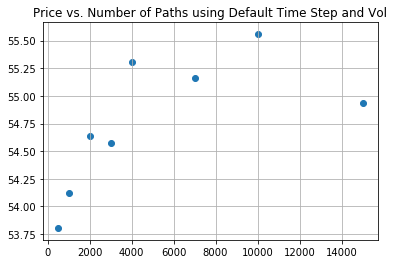

In [21]:
pathvals = []
for path in [500,1000,2000,3000,4000,7000,10000, 15000]:
    pathvals.append(Scheme1(.2, 12, path))
    
fig, ax = plt.subplots()
ax.scatter([500,1000,2000,3000,4000,7000,10000, 15000], pathvals, alpha=1)
ax.set_title("Price vs. Number of Paths using Default Time Step and Vol")
ax.grid(True)

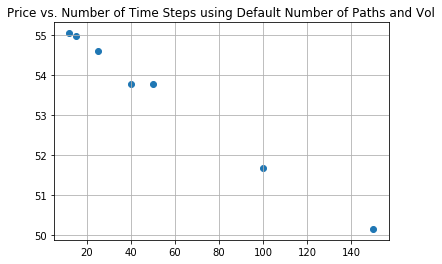

In [22]:
stepvals = []
for step in [12,15,25,40,50,100,150]:
   stepvals.append(Scheme1(.2, step,5000))
    
fig, ax = plt.subplots()
ax.scatter([12,15,25,40,50,100,150], stepvals, alpha=1)
ax.set_title("Price vs. Number of Time Steps using Default Number of Paths and Vol")
ax.grid(True)

- The three plots above show how varying the volatility, increment size, and number of paths affected the pricing of the option. The results are what we would expect from how these parameters affect the UVM model using a BSDE numerical scheme.

- As the number of paths was increased (using the default vol and time steps), the closer to the true price the result became, but in general, after the initial number of runs was around 5000, there was not a consistent increase in accuracy. This is due to the initial run being used to calculate the regression function, and once there are enough paths to ensure some degree of accuracy, using more and more paths has a diminishing effect. THe independent run, when using more and more paths, also leads to higher accuracy, but again, the randomness of the simulation does not ensure that more paths leads to a more accurate result. 

- As the time steps were increased/the increment was decreased, the performance of the BSDE scheme plummeted dramatically. This was characteristic of the how the numerical scheme diverges for too small increments. In this case, when the increment was decreased past $1/20$ the performance began to decrease, and as the increments were decreased past that, the price went lower and lower indicating that more paths are needed for using such small time steps.

- In the case of the simulation volatility, the best performance was from $20\%$ to $40\%$ vols, but the higher vols (even unreasonably so, like $60\%$ and $70\%$) usually did not result in huge deviations from the true price. The case of a large error was when $5\%$ vol was used, which indicates that the initial simulation should be ran with reasonable volatilities so that the BSDE scheme adjustments do not have to be extremely accurate to result in a reasonable value. 

#### Question 1b.)

In [23]:
def Scheme2():
    nsteps = 12
    ts = np.linspace(0, T, nsteps+1)
    nknots = 15
    vol = 0.2
    npaths = 5000
    #dW stores the brownian increments. The ith index is the increment from time t_{i-1} to t_i
    #so dW[0,:] = 0, and isn't an actual increment
    dW = np.vstack((np.zeros((1, npaths), dtype=np.float),
                    np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts))[:, np.newaxis]))

    W = np.cumsum(dW, axis=0)
    X = np.exp(-0.5*vol**2*ts[:, np.newaxis] + vol*W)*X0


    xps = np.full((len(ts), nknots), np.nan, dtype=np.float)
    gps = np.full((len(ts), nknots), np.nan, dtype=np.float)

    Y = g(X[-1])

    for i in range(len(ts)-2, 0, -1):
        dt = ts[i+1] - ts[i]
        #store the knot locations for the ith time at the ith index
        xps[i] = np.linspace(np.percentile(X[i], 1), np.percentile(X[i], 99), nknots)
        #predict t_{i+1}'s Y value using time t_i's X value
        yE = np.interp(X[i], xps[i], piecewiselinear_fit(X[i], Y, xps[i]))
        #store predictor of gamma at time t_i 
        gps[i] = piecewiselinear_fit(X[i], ((Y*((dW[i+1]*dW[i+1]) - (dt*(1 + vol*dW[i+1]))))/((dt*vol*X[i])*(dt*vol*X[i]))), xps[i])
        #calculate the gamma using regression
        G = np.interp(X[i], xps[i], gps[i])
        #calculate t_i's Y value and store it in the vector
        Y = yE + dt/2*X[i]**2*G*(Sigma(G)**2-vol**2)

    dt = ts[1]-ts[0]
    # in the last step of backward induction, the conditional expectations reduce to the mean values 
    G = np.mean(((Y*((dW[1]*dW[1]) - (dt*(1 + vol*dW[1]))))/((dt*vol*X0)*(dt*vol*X0))))
    volp = Sigma(G)

    # # # independent simulation to get a lower bound price # # #

    npaths = 2**15
    # we use more discretization time steps in this second run to simulate accurately the (nearly) optimal X process
    nsteps = 400
    Dt = ts[1]-ts[0]
    ts_ = np.linspace(0, T, nsteps+1)
    dW = np.vstack((np.zeros((1, npaths), dtype=np.float),
                    np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts_))[:, np.newaxis]))
    X = np.full((len(ts_), npaths), np.nan, dtype=np.float)
    X[0] = X0

    #calculating for all the times that will use the last step vol
    m = int(round(ts[1]/(ts_[1]-ts_[0])))
    #goes up to m, so X[m] is known at the end of the for loop
    for i in range(1, m+1):
        dt = ts_[i] - ts_[i-1]
        X[i] = X[i-1]*np.exp(-0.5*volp**2*dt+dW[i]*volp)

    #go through rest of the indices normally    
    for i in range(m+1, len(ts_)):
        dt = ts_[i] - ts_[i-1]
        #determine under which gamma regression function the current time step should go
        #since we are beginning at m+1 no matter what, the value of j before minusing 1 will be ceil(>)
        j = int(np.ceil(ts_[i]/Dt))-1
        #estimate the optimal vol for the increment i-1 to i using time i-1's state variable and gamma regression 
        vols = Sigma(np.interp(X[i-1], xps[j], gps[j]))
        #calculate the actual X value at time i using the optimal vol
        X[i] = X[i-1]*np.exp(-0.5*vols**2*dt+dW[i]*vols)

    return(np.mean(g(X[-1])))

In [24]:
print("Scheme 2 Price = {}".format(Scheme2()))

Scheme 2 Price = 54.200789144952374


- The price using Scheme 2 was consistently lower than that of using Scheme 1, where the average value using Scheme2 was near $53.5\text{USD}$, the average value using Scheme 1 was near $55.5\text{USD}$. The benefit of Scheme2 was mostly a consistent increase in runtime of around $.1$ seconds for $5000$ paths. This increase is larger as the number of paths used increased, and the resulting price using more paths was also more accurate, although still not as accurate as Scheme1 using much fewer paths. There was much higher variance in the resulting prices using Scheme2, so in this particular case, it seems that (all else equal) Scheme 1 was a better choice, but Scheme 2 could be valuable when runtime is essential.

#### Question 1c.)

In [25]:
def Scheme2a():
    nsteps = 12
    ts = np.linspace(0, T, nsteps+1)
    nknots = 15
    vol = 0.2
    npaths = 5000
    #dW stores the brownian increments. The ith index is the increment from time t_{i-1} to t_i
    #so dW[0,:] = 0, and isn't an actual increment
    dW = np.vstack((np.zeros((1, npaths), dtype=np.float),
                    np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts))[:, np.newaxis]))

    W = np.cumsum(dW, axis=0)
    X = np.exp(-0.5*vol**2*ts[:, np.newaxis] + vol*W)*X0


    xps = np.full((len(ts), nknots), np.nan, dtype=np.float)
    gps = np.full((len(ts), nknots), np.nan, dtype=np.float)

    Y = g(X[-1])

    for i in range(len(ts)-2, 0, -1):
        dt = ts[i+1] - ts[i]
        #store the knot locations for the ith time at the ith index
        xps[i] = np.linspace(np.percentile(X[i], 1), np.percentile(X[i], 99), nknots)
        #predict t_{i+1}'s Y value using time t_i's X value
        yE = np.interp(X[i], xps[i], piecewiselinear_fit(X[i], Y, xps[i]))
        #store predictor of gamma at time t_i 
        gps[i] = piecewiselinear_fit(X[i], (((Y - yE)*((dW[i+1]*dW[i+1]) - (dt*(1 + vol*dW[i+1]))))/((dt*vol*X[i])*(dt*vol*X[i]))), xps[i])
        #calculate the gamma using regression
        G = np.interp(X[i], xps[i], gps[i])
        #calculate t_i's Y value and store it in the vector
        Y = yE + dt/2*X[i]**2*G*(Sigma(G)**2-vol**2)

    dt = ts[1]-ts[0]
    # in the last step of backward induction, the conditional expectations reduce to the mean values 
    G = np.mean(((Y*((dW[1]*dW[1]) - (dt*(1 + vol*dW[1]))))/((dt*vol*X0)*(dt*vol*X0))))
    volp = Sigma(G)

    # # # independent simulation to get a lower bound price # # #

    npaths = 2**15
    # we use more discretization time steps in this second run to simulate accurately the (nearly) optimal X process
    nsteps = 400
    Dt = ts[1]-ts[0]
    ts_ = np.linspace(0, T, nsteps+1)
    dW = np.vstack((np.zeros((1, npaths), dtype=np.float),
                    np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts_))[:, np.newaxis]))
    X = np.full((len(ts_), npaths), np.nan, dtype=np.float)
    X[0] = X0

    #calculating for all the times that will use the last step vol
    m = int(round(ts[1]/(ts_[1]-ts_[0])))
    #goes up to m, so X[m] is known at the end of the for loop
    for i in range(1, m+1):
        dt = ts_[i] - ts_[i-1]
        X[i] = X[i-1]*np.exp(-0.5*volp**2*dt+dW[i]*volp)

    #go through rest of the indices normally    
    for i in range(m+1, len(ts_)):
        dt = ts_[i] - ts_[i-1]
        #determine under which gamma regression function the current time step should go
        #since we are beginning at m+1 no matter what, the value of j before minusing 1 will be ceil(>)
        j = int(np.ceil(ts_[i]/Dt))-1
        #estimate the optimal vol for the increment i-1 to i using time i-1's state variable and gamma regression 
        vols = Sigma(np.interp(X[i-1], xps[j], gps[j]))
        #calculate the actual X value at time i using the optimal vol
        X[i] = X[i-1]*np.exp(-0.5*vols**2*dt+dW[i]*vols)

    return(np.mean(g(X[-1])))

In [26]:
print("Scheme 2a Price = {}".format(Scheme2a()))

Scheme 2a Price = 55.420502439120774


In [27]:
#calculating the results of 20 runs
Scheme2results = [Scheme2() for i in range(0,20,1)]
Scheme2aresults = [Scheme2a() for i in range(0,20,1)]

#outputting variance and mean
print("Unbiased Sample Variance Estimate for Scheme2 = {}".format(np.var(Scheme2results, ddof=1)))
print("Unbiased Sample Variance Estimate for Scheme2a = {}".format(np.var(Scheme2aresults, ddof=1)))
print("Average of Scheme2 = {}".format(np.mean(Scheme2results)))
print("Average of Scheme2a = {}".format(np.mean(Scheme2aresults)))

Unbiased Sample Variance Estimate for Scheme2 = 0.3217816734479871
Unbiased Sample Variance Estimate for Scheme2a = 0.15192259789288212
Average of Scheme2 = 53.74425420760126
Average of Scheme2a = 54.83605497536347


- The use of the control variate reduced the variance dramatically in this case. The variance using Scheme2a was around .1 while the variance using Scheme2 was around .3. For Scheme2, this meant that the typical deviation in between different valuations was substantial, and this reflected the experience when running Scheme2 manually. Scheme2a also resulted in an average price estimate $1.50\text{USD}$ closer to the actual than using Scheme2, another benefit of the reduction in variance.

- The calculation is unchanged since 
\begin{align*}
\mathbb{E}_{i-1}\left[\mathbb{E}_{i-1}\left[Y_{t_i}\right]\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right] = \mathbb{E}_{i-1}\left[Y_{t_i}\right]\cdot \mathbb{E}_{i-1}\left[\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right] \\
= \mathbb{E}_{i-1}\left[Y_{t_i}\right]\cdot \left(\mathbb{E}_{i-1}\left[\Delta W_{t_i}^2\right]-\mathbb{E}_{i-1}\left[\Delta t_i \right]  + \mathbb{E}_{i-1}\left[ \hat{\sigma}\Delta W_{t_i}\right]\right) = \mathbb{E}_{i-1}\left[Y_{t_i}\right]\cdot \left(\Delta t_i-\Delta t_i  + 0\right) = 0
\end{align*}
and so a term of $0$ is essentially being added which has no effect on the actual equation, but serves to reduce the variance. 

<h3 style="color:deepskyblue">The particle Method and Smile Calibration</h3>

<b style="color:darkorange">Question 2.</b> Consider the stochastic local volatility (SLV) model

$$
\begin{array}{l}
dS_t = a_t l(t, S_t) S_t dW^{(1)}_t\\
a_t=\sigma_0 e^{Y_t}\quad\text{where}\quad d Y_t = -\kappa Y_tdt+\gamma dW^{(2)}_t\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

The numerical values for the model parameters are
- $T = 1$.
- $S_0 = 100$.
- $\sigma_0 = 15\%$.
- $Y_0 = 0$.
- $\rho = -50\%$.
- $\gamma = 50\%$.
- $\kappa = 1$.

The goal is to find a leverage function $l(t, S)$ so that this model matches the market prices of vanilla options. For the sake of simplicity, we assume that the market implied volatility surface is flat $\sigma_{\textrm{Market}} \equiv 15\%$. In that case, we also have $\sigma_{\textrm{Dup}}(t,S) \equiv 15\%$.

Note that the above SLV model becomes a pure stochastic volatility model when the leverage function is identically equal to 1. Below we describe a Monte Carlo simulation scheme for the pure stochastic volatility model. You can modify it to simulate and calibrate the SLV model.

First we discretize the interval $(0,T)$ into subintervals $(t_{i-1}, t_i)$, $1\leq i\leq n$, and set $\Delta t_i=t_i-t_{i-1}$. 

The Ornstein-Uhlenbeck process $Y$ is explicitly solvable:
\begin{equation}
Y_{t_i}=e^{-\kappa\Delta t_i}Y_{t_{i-1}}+\int_{t_{i-1}}^{t_i}\gamma e^{\kappa\left(s-t_i\right)}dW_s^{(2)}.
\end{equation}

Therefore for given $Y_{t_{i-1}}$, $Y_{t_i}$ is a Gaussian variable with 
\begin{equation}\tag{1}
\mathbb{E}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=e^{-\kappa\Delta t_i}Y_{t_{i-1}},\quad
\text{var}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=\frac{\gamma^2}{2\kappa}\left(1-e^{-2\kappa\Delta t_i}\right)
\end{equation}

so that paths of $Y$ can be simulated exactly.

To simualte the spot process $S$, we use the Euler scheme:
$$\log S_{t_i}-\log S_{t_{i-1}}=-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}\Delta t_i+\sigma_0 e^{Y_{t_{i-1}}}\int_{t_{i-1}}^{t_i}dW^{(1)}_t$$

Thus for given $S_{t_{i-1}}$ and $Y_{t_{i-1}}$, $\log S_{t_i}$ and $Y_{t_i}$ are jointly Gaussian variables with

\begin{equation}\tag{2}
\mathbb{E}\left[\left.\log S_{t_i}\right\vert S_{t_{i-1}},Y_{t_{i-1}}\right]=\log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}\Delta t_i,\quad\text{Var}\left[\left.\log S_{t_i}\right\vert S_{i_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0^2e^{2Y_{t_{i-1}}}\Delta t_i
\end{equation}

\begin{equation}\tag{3}
\text{Cov}\left[\left.Y_{t_i},\log S_{t_i}\right\vert S_{t_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0 e^{Y_{t_{i-1}}}\frac{\gamma\rho}{\kappa}\left(1-e^{-\kappa\Delta t_i}\right)
\end{equation}

Over the time interval $[t_{i-1}, t_i]$, we can advance $\log S$ and $Y$ by generating Gaussian variables $\log S_{t_i}$ and $Y_{t_i}$ using equations (1)-(3).

# <b>(a).</b> Implementation of the Particle Method.
- Implement the particle method studied in class to find the leverage function $l$. For this purpose, you may use the zero-th order non-parametric regression routine provided in the first assignment. We suggest that you use the quartic kernel

$$K(x)=(x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{ elsewhere}$$

together with the bandwidth 

$$h = \kappa \sigma_{\mathrm{Market}} S_0 \sqrt{\max(t_k,0.15)}N^{-0.2}$$

at discretization date $t_k$. Make sure to fine-tune the dimensionless bandwidth parameter $\kappa$. Its order of magnitude is 1.0. Use $\Delta t = 1/100$, $N=10,000$ paths. Note: In class, we described an acceleration technique that involves sorting the "particles" $(S_{t_k},a_{t_k})$ according to the spot value $S_{t_k}$. Since the kernel we have chosen has compact support and is fairly inexpensive to evaluate, you may ignore this acceleration technique here. This means that each estimation of a conditional expectation $\mathbb{E}\left[\left.a_{t_k}^2\right\vert S_{t_k}=x\right]$ (for $x$ in a grid of spot values) involves the ratio of two sums of $N$ terms each.

- Check that the resulting model is indeed calibrated to the market implied volatilities $\sigma_{\textrm{Market}} \equiv 15\%$. To this end, compute estimates of the call prices (maturity $T=1$) in the calibrated model for strikes $70, 80, 90, 100, 110, 120, 130, 140$, and invert the Black-Scholes formula to get the corresponding estimation of the implied volatilities $\hat\sigma(T,K)$. To estimate the call prices in the calibrated model, simulate a new set of independent paths with the calibrated leverage function $l$ and $N_2 = 100,000$ paths. For the inversion of the Black-Scholes formula, you can use the function <code>blackscholes_impv</code> provided below.

<b>(b).</b> Fix the spot-vol correlation $\rho = 0\%$ and mean reversion $\kappa=1$. We study the impact of volatility of volatility $\gamma$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\gamma$. Suggested values of $\gamma$: $0\%$, $25\%$, $50\%$, $75\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\gamma$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the leverage function on $\gamma$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the smile on $\gamma$.

<b>(c).</b> Fix the volatility of volatility $\gamma = 50\%$ and mean reversion $\kappa=1$. We study the impact of spot-vol correlation $\rho$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\rho$. Suggested values of $\rho$: $-50\%$, $0\%$, $50\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\rho$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\rho$ in the same graph. Comment on the dependence of the shape of the leverage function on $\rho$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\rho$ in the same graph. Comment on the dependence of the shape of the smile on $\rho$.

<b>(d).</b> Fix the spot-vol correlation $\rho = 0\%$ and volatility of volatility $\gamma = 50\%$. We study the impact of mean reversion $\kappa$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\kappa$. Suggested values of $\kappa$: $0.1$, $1$, $10$.
- Recalibrate the leverage function $l(t,S)$ for each $\gamma$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the leverage function on $\kappa$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\kappa$ in the same graph. Comment on the dependence of the shape of the smile on $\kappa$.

<b>(e).</b> Consider the forward-starting straddle with payoff
\begin{equation*}
\left\vert \frac{S_{T_2}}{S_{T_1}}-1 \right\vert
\end{equation*}
with $T_1 = T - \frac{3}{12}$, $T_2 = T$. Use $\gamma = 100\%$, $\rho = -50\%$ and $\kappa=1$. Compare the prices of this option in the Black-Scholes model with volatility 15% and in the calibrated SLV model. Comment on the result. Why is it of interest to use stochastic local volatility models for pricing derivatives?

In [28]:
def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option.
    S: scalar or array_like
        The spot price of the underlying security.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S*np.exp((r-q)*T)
    w = vol**2*T
    d1 = (np.log(F/K)+0.5*w)/np.sqrt(w)
    d2 = d1 - np.sqrt(w)
    callput = callput.lower()
    if callput == 'call':
        opttype = 1
    elif callput == 'put':
        opttype = -1
    else:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = (opttype*F*norm.cdf(opttype*d1)-opttype*K*norm.cdf(opttype*(d2)))*np.exp(-r*T)
    return price

In [29]:
# all inputs must be scalar
def blackscholes_impv_scalar(K, T, S, value, r=0, q=0, callput='call', tol=1e-6, maxiter=500):
    """Compute implied vol in Black-Scholes model
    
    Parameters
    ----------
    K: scalar
        The strike of the option.
    T: scalar
        The maturity of the option.
    S: scalar
        The spot price of the underlying security.
    value: scalar
        The value of the option
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    vol: scalar
        The implied vol of the option.
    """
    if (K <= 0) or (T <= 0):
        return np.nan
    F = S*np.exp((r-q)*T)
    K = K/F
    value = value*np.exp(r*T)/F
    callput = callput.lower()
    if callput not in ['call', 'put']:
        raise ValueError('The value of "callput" must be either "call" or "put"')
    opttype = 1 if callput == 'call' else -1
    value -= max(opttype * (1 - K), 0)
    if value < 0:
        return np.nan
    if (value == 0):
        return 0
    j = 1
    p = np.log(K)
    if K >= 1:
        x0 = np.sqrt(2 * p)
        x1 = x0 - (0.5 - K * norm.cdf(-x0) - value) * np.sqrt(2*np.pi)
        while (abs(x0 - x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1 - (norm.cdf(d1) - K*norm.cdf(d1-x1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1 / np.sqrt(T)
    else:
        x0 = np.sqrt(-2 * p)
        x1 = x0 - (0.5*K-norm.cdf(-x0)-value)*np.sqrt(2*np.pi)/K
        while (abs(x0-x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1-(K*norm.cdf(x1-d1)-norm.cdf(-d1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1/np.sqrt(T)

# vectorized version
blackscholes_impv = np.vectorize(blackscholes_impv_scalar, excluded={'callput', 'tol', 'maxiter'})

# Example
#blackscholes_impv(K=95, T=0.25, S=100, value=7, callput='call')

In [30]:
def quartic_kernel(x):
    x = np.clip(x, -1, 1)
    return (x+1)**2*(1-x)**2

def kern_reg(x, xdata, ydata, bandwidth, kern=quartic_kernel):
    """Nadaraya-Watson Kernel Regression (Locally weighted average)

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    weights = kern((xdata[:, np.newaxis] - x) / bandwidth)
    return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)


####  Question 2a.)

In [31]:
def SLVmodel(volvol, spotvolcor, reversion, SLV_or_SV = "SLV"):
    S0 = 100.0
    T = 1
    vol = .15
    rho = spotvolcor
    gamma = volvol
    kappa = reversion
    market_vol = .15
    dup_vol = .15

    npaths= 10000
    nsteps = 100
    ts = np.linspace(0, T, nsteps+1)
    increment = ts[1] - ts[0]

    #Ornstein Uhlenbeck is denoted X and Log S process is denoted Y
    XSNRV = np.vstack((np.full((1, npaths), np.nan, dtype=np.float),
                    np.random.randn(nsteps, npaths)))

    ZSNRV = np.vstack((np.full((1, npaths),np.nan, dtype=np.float),
                    np.random.randn(nsteps, npaths)))
    Y = np.full_like(XSNRV[0,:], np.nan)
    X = np.full_like(XSNRV[0,:], np.nan)
    L = np.full_like(XSNRV[0,:], np.nan)

    minmaxidx = int(round(.001 * npaths))

    #create matrices to store the data from calculating Leverage function for independent runs
    #LS =np.full_like(XSNRV, np.nan)
    #LA = np.full_like(XSNRV, np.nan)
    #Lb = np.full_like(XSNRV[:,0], np.nan)


    lev =  np.full_like(XSNRV[:,0], np.nan).tolist()

    #initial values
    X[:] = 0.0
    Y[:]= np.log(S0)
    
    if SLV_or_SV == "SLV":
        L[:] = dup_vol / (vol*np.exp(X))
    else:
        L = 1.0

    X_var = ((gamma*gamma / (2 * kappa)) * (1 - np.exp(-2.0 * kappa * increment)))
    corr = (((np.sqrt(2.0 / (kappa * increment)) * rho) * np.sqrt(1 - np.exp(-1.0 * kappa * increment))) / np.sqrt(1 + np.exp(-1.0 * kappa * increment)))
    #at time i, we calculate the increment from i-1 to i
    for i in range(1, nsteps+1,1):
        increment = ts[i] - ts[i-1]
        bandwidth = 1.5 * S0 * market_vol * np.sqrt(np.maximum(ts[i], 0.15)) * (npaths**(-0.2))
        #calculate the random term of the log S process
        term = corr * XSNRV[i] + (np.sqrt(1 - corr*corr) * ZSNRV[i])
        #calculate the new logS value
        Y = (Y) - (0.5*vol*vol*np.exp(2 * X) * (L * L)* increment) + (np.sqrt(increment) *vol*np.exp(X) *L * term)
        #Calculate the value of the Ornstein Uhlenbeck
        X = (np.exp(-1.0 * kappa* increment) * X) + (np.sqrt(X_var) * XSNRV[i])
        if SLV_or_SV == "SLV":
            #calculate a
            a = vol * np.exp(X)
            #calculate leverage function for the next time
            Nft = int(round(np.maximum(30 * np.sqrt(ts[i]), 15)))
            vals = np.linspace((np.exp(Y)[np.exp(Y).argsort()][minmaxidx]),(np.exp(Y)[np.exp(Y).argsort()][-minmaxidx]),Nft)
            Ltemp = dup_vol / (np.sqrt(kern_reg(vals, np.exp(Y), a*a, bandwidth)))
            vals = vals[~np.isnan(Ltemp)]
            Ltemp = Ltemp[~np.isnan(Ltemp)]
            lev[i] = CubicSpline(vals, Ltemp, extrapolate=bool)
            L = lev[i](np.exp(Y))
        else:
            L = 1.0
        

    #independent run
    npaths= 100000
    nsteps = 100
    ts = np.linspace(0, T, nsteps+1)
    increment = ts[1] - ts[0]
    XSNRV = np.vstack((np.full((1, npaths), np.nan, dtype=np.float),
                    np.random.randn(nsteps, npaths)))

    ZSNRV = np.vstack((np.full((1, npaths),np.nan, dtype=np.float),
                    np.random.randn(nsteps, npaths)))

    #initial values
    Y = np.full_like(XSNRV[0,:], np.nan)
    X = np.full_like(XSNRV[0,:], np.nan)
    L = np.full_like(XSNRV[0,:], np.nan)
    X[:] = 0.0
    Y[:]= np.log(S0)
    if SLV_or_SV == "SLV":
        L[:] = dup_vol / (vol*np.exp(X))
    else:
        L = 1.0
    X_var = ((gamma*gamma / (2 * kappa)) * (1 - np.exp(-2.0 * kappa * increment)))
    corr = (((np.sqrt(2.0 / (kappa * increment)) * rho) * np.sqrt(1 - np.exp(-1.0 * kappa * increment))) / np.sqrt(1 + np.exp(-1.0 * kappa * increment)))
    #at time i, we calculate the increment from i-1 to i
    for i in range(1, nsteps+1,1):
        increment = ts[i] - ts[i-1]
        #calculate the random term of the log S process
        term = corr * XSNRV[i] + (np.sqrt(1 - corr*corr) * ZSNRV[i])
        #calculate the new logS value
        Y = (Y) - (0.5*vol*vol*np.exp(2 * X) * (L * L)* increment) + (np.sqrt(increment) *vol*np.exp(X) *L * term)
        #Calculate the value of the Ornstein Uhlenbeck
        X = (np.exp(-1.0 * kappa* increment) * X) + (np.sqrt(X_var) * XSNRV[i])
        #calculate leverage function for the next time
        if SLV_or_SV == "SLV":
            L = lev[i](np.exp(Y))
        else:
            L = 1.0
    
    return (Y,lev)

In [32]:
def callcalc(strike, vec):
    vec = vec[~np.isnan(vec)]
    return np.mean(np.maximum(vec - strike, 0))
Y = SLVmodel(0.5,-0.5, 1.0)[0]
SLVresults = [blackscholes_impv(K=i, T=1, S=100, value=callcalc(i,np.exp(Y)), callput='call') for i in [70,80,90,100,110,120,130,140]]
Y = SLVmodel(0.5,-0.5, 1.0, "Pure SV")[0]
SVresults = [blackscholes_impv(K=i, T=1, S=100, value=callcalc(i,np.exp(Y)), callput='call') for i in [70,80,90,100,110,120,130,140]]

import pandas as pd
pd.DataFrame(np.vstack((SLVresults, SVresults)), index = ["SLV", "SV"],columns = [70,80,90,100,110,120,130,140]).transpose()

,SLV,SV
70,NaN,0.196446
80,0.147025,0.179443
90,0.148962,0.166295
100,0.149208,0.155922
110,0.148996,0.148175
120,0.148529,0.142983
130,0.147624,0.140149
140,0.145515,0.139460


- The results from the calibration were extremely accurate, especially when the number of paths simulated was increased for the first and independent runs. The IV implied from the calibrated model prices were nearly $15\%$ for the strikes of $90,100,110,120$ and was typically around $.3\%$ off for the $80,130, 140$ strikes. This made sense since the higher strikes were furthest from the starting price and so fewer paths had values in that range and thus the Kernel regression/spline interpolation led to slightly less accurate leverage function values. 

- For the case of the $70$ strike, there was an issue that the Implied Volatility inversion function led to NaN values for prices less than $30$ and in the few cents range above $30$, the IV ranged from $13\%$ to $20\%$ (as shown below). As the price resulting from the model typically has a few cents variability at the least, this meant that some runs returned NaN values, while others returned IVs in the large range possible.

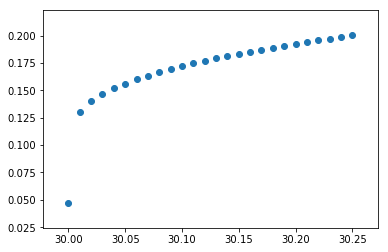

In [33]:
plt.scatter(np.arange(29.9, 30.25, .01),[blackscholes_impv(K=70, T=1, S=100, value=i, callput='call') for i in np.arange(29.9, 30.25, .01)])

#### Question 2b.)

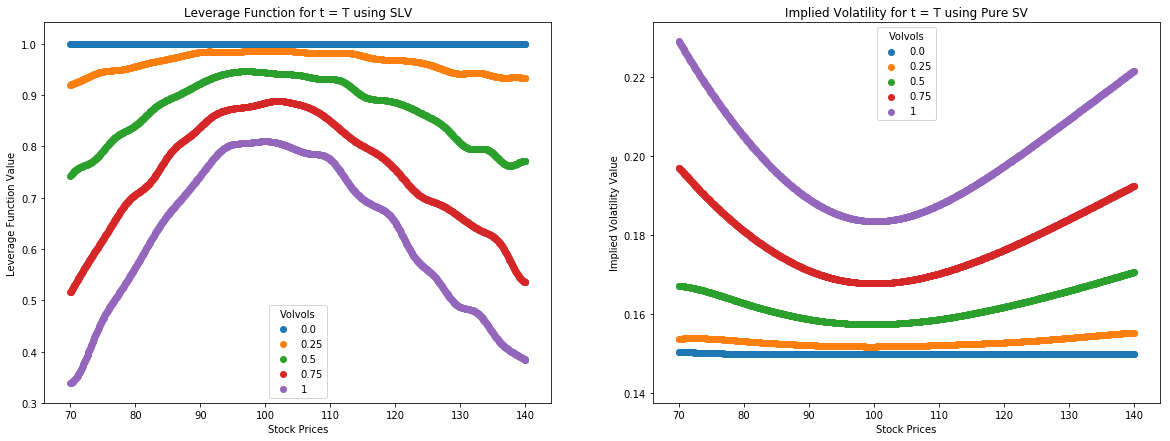

In [34]:
fig,ax = plt.subplots(1,2, figsize = [20,7])
volvols =[0.0,0.25,0.5,0.75,1]
for volvol in volvols:
    ax[0].scatter(np.linspace(70,140,1000), SLVmodel(volvol, 0.0,1.0)[1][-1](np.linspace(70,140,1000)), label = "{}".format(volvol))
    Y = SLVmodel(volvol,0, 1.0, "Pure SV")[0]
    SVresults = [blackscholes_impv(K=i, T=1, S=100, value=callcalc(i,np.exp(Y)), callput='call') for i in np.linspace(70,140,1000)]
    ax[1].scatter(np.linspace(70,140,1000), SVresults, label = "{}".format(volvol))

names = [["SLV", "Leverage Function"], ["Pure SV", "Implied Volatility"]]
for i in [0,1]:
    ax[i].legend(title = "Volvols" ,loc=0)
    ax[i].set_title("{} for t = T using {}".format(names[i][1], names[i][0]))
    ax[i].set_xlabel("Stock Prices")
    ax[i].set_ylabel("{} Value".format(names[i][1]))

- In all the graphs of Leverage Function vs Price (using SLV) and IV vs. Price (using SV), there are some general patterns that result from the requirement that for calibration the leverage function has to equal ratio of the market smile to the square root of the conditional expectation of the $a_t$ term in the stock price dynamics. This means that, in general (especially when close to maturity), the two charts will be providing similar information. When the IV of the SV model is such that the market smile is exactly matched, then the leverage function will be $1$ for all strikes as the SV model incorporates the market smile properly without need for adjustment. As the implied volatility increases from the market value, the leverage function acts as a scale factor, scaling down the overall volatility in order to fulfill the condition for calibration. This is why when there is 'smile' in the IV chart using SV, there is 'frown' in the SLV chart.

- In general, the increase in volvol meant that the variance/volatility of the stock price would increase and therefore the likelihood of stock prices further from the time $0$ price is higher and thus there is larger IV as one moves away from the ATM price. This trend is seen throughout, as the larger values for volvol not only increases the degree of the smile but also increases the IV across all strikes as well. 

#### Question 2c.)

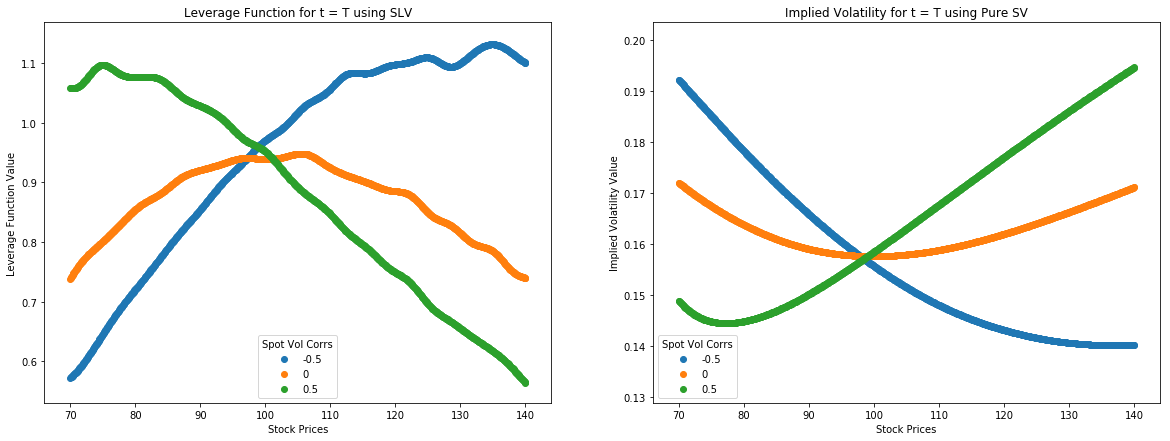

In [35]:
fig,ax = plt.subplots(1,2, figsize = [20,7])
spotvolcorrs =[-0.5, 0, 0.5]
for spotvolcorr in spotvolcorrs:
    ax[0].scatter(np.linspace(70,140,1000), SLVmodel(0.5, spotvolcorr, 1.0)[1][-1](np.linspace(70,140,1000)), label = "{}".format(spotvolcorr))
    Y = SLVmodel(0.5,spotvolcorr, 1.0, "Pure SV")[0]
    SVresults = [blackscholes_impv(K=i, T=1, S=100, value=callcalc(i,np.exp(Y)), callput='call') for i in np.linspace(70,140,1000)]
    ax[1].scatter(np.linspace(70,140,1000), SVresults, label = "{}".format(spotvolcorr))

names = [["SLV", "Leverage Function"], ["Pure SV", "Implied Volatility"]]
for i in [0,1]:
    ax[i].legend(title = "Spot Vol Corrs", loc=0)
    ax[i].set_title("{} for t = T using {}".format(names[i][1], names[i][0]))
    ax[i].set_xlabel("Stock Prices")
    ax[i].set_ylabel("{} Value".format(names[i][1]))

- The leverage function and IV charts show the same corresponding pattern as discussed earlier when the spot-vol correlation is varied. When there was no correlation between the spot price and the vol, the leverage function is 'frowning' and the IV is 'smiling', which corresponds to the fact that when there is no correlation there is no particularly likelihood of the spot and vol moving in similar directions, and thus the overall effect is that moving ATM leads to increases in IV. In the case of negative correlation, and upward swing in stock prices would be more likely accompanied by a drop in the vol, and so IV is low for larger strikes and high for lower strikes. This is also seen in the leverage function curve, where the value is $>1$ at the highest strikes in order to have the calibration to $15\%$ market smile. When there is positive correlation, the upward swings would likely be accompanied by increases in vol, and therefore the IV is upward sloping as strikes increase.  

#### Question 2d.)

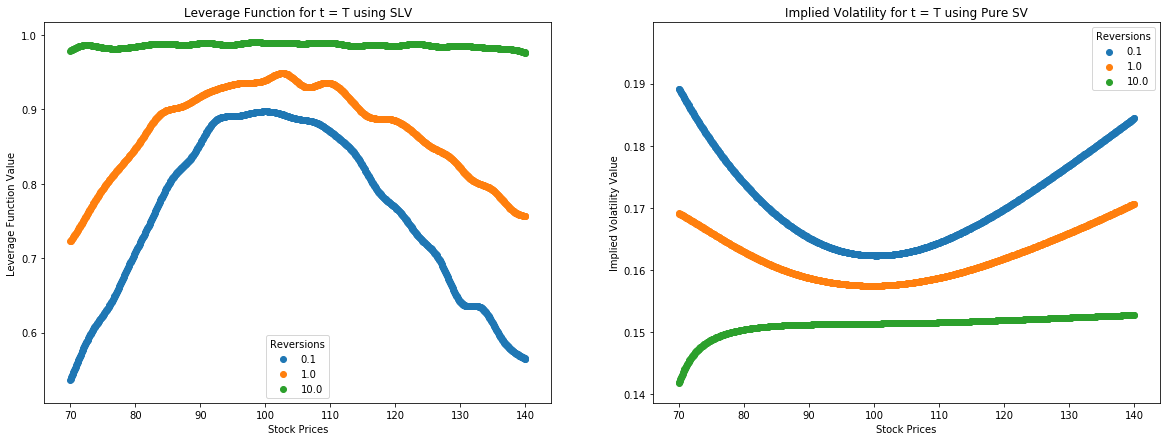

In [36]:
fig,ax = plt.subplots(1,2, figsize = [20,7])
reversions =[0.1,1.0, 10.0]
for reversion in reversions:
    ax[0].scatter(np.linspace(70,140,1000), SLVmodel(0.5, 0, reversion)[1][-1](np.linspace(70,140,1000)), label = "{}".format(reversion))
    Y = SLVmodel(0.5,0, reversion, "Pure SV")[0]
    SVresults = [blackscholes_impv(K=i, T=1, S=100, value=callcalc(i,np.exp(Y)), callput='call') for i in np.linspace(70,140,1000)]
    ax[1].scatter(np.linspace(70,140,1000), SVresults, label = "{}".format(reversion))

names = [["SLV", "Leverage Function"], ["Pure SV", "Implied Volatility"]]
for i in [0,1]:
    ax[i].legend(title = "Reversions", loc=0)
    ax[i].set_title("{} for t = T using {}".format(names[i][1], names[i][0]))
    ax[i].set_xlabel("Stock Prices")
    ax[i].set_ylabel("{} Value".format(names[i][1]))

- The same pattern between the leverage function and IV charts is present in this case as well. When the mean reversion speed is very large, the volvol is more quickly moving towards $0$ and thus the result is that the $a_t$ term is closer to the initial vol, which is also the correct market smile in this case, and so the leverage function and IV are flat and $1$ and $15\%$ respectively. In the case of the slower mean reversions, we see that the volvol has a much larger impact on the stock price dynamics, and therefore (in the case of 0 correlation) leads to the smile in the IV and frown in the leverage functions, with the effect decreasing as the mean reversion speed increases.

#### Question 2e.)

In [39]:
def SLV_straddle(SLV_or_SV = "SLV"):
    S0 = 100.0
    T = 1
    vol = .15
    rho = -0.5
    gamma = 1
    kappa = 1
    market_vol = .15
    dup_vol = .15

    npaths= 10000
    nsteps = 100
    ts = np.linspace(0, T, nsteps+1)
    increment = ts[1] - ts[0]

    #Ornstein Uhlenbeck is denoted X and Log S process is denoted Y
    XSNRV = np.vstack((np.full((1, npaths), np.nan, dtype=np.float),
                    np.random.randn(nsteps, npaths)))

    ZSNRV = np.vstack((np.full((1, npaths),np.nan, dtype=np.float),
                    np.random.randn(nsteps, npaths)))
    Y = np.full_like(XSNRV[0,:], np.nan)
    X = np.full_like(XSNRV[0,:], np.nan)
    L = np.full_like(XSNRV[0,:], np.nan)

    minmaxidx = int(round(.001 * npaths))


    lev =  np.full_like(XSNRV[:,0], np.nan).tolist()
    #initial values
    X[:] = 0.0
    Y[:]= np.log(S0)
    L[:] = dup_vol / (vol*np.exp(X))

    X_var = ((gamma*gamma / (2 * kappa)) * (1 - np.exp(-2.0 * kappa * increment)))
    corr = (((np.sqrt(2.0 / (kappa * increment)) * rho) * np.sqrt(1 - np.exp(-1.0 * kappa * increment))) / np.sqrt(1 + np.exp(-1.0 * kappa * increment)))
    #at time i, we calculate the increment from i-1 to i
    for i in range(1, nsteps+1,1):
        increment = ts[i] - ts[i-1]
        bandwidth = 1.5 * S0 * market_vol * np.sqrt(np.maximum(ts[i], 0.15)) * (npaths**(-0.2))
        #calculate the random term of the log S process
        term = corr * XSNRV[i] + (np.sqrt(1 - corr*corr) * ZSNRV[i])
        #calculate the new logS value
        Y = (Y) - (0.5*vol*vol*np.exp(2 * X) * (L * L)* increment) + (np.sqrt(increment) *vol*np.exp(X) *L * term)
        #Calculate the value of the Ornstein Uhlenbeck
        X = (np.exp(-1.0 * kappa* increment) * X) + (np.sqrt(X_var) * XSNRV[i])
        #calculate a
        a = vol * np.exp(X)
        #calculate leverage function for the next time
        Nft = int(round(np.maximum(30 * np.sqrt(ts[i]), 15)))
        vals = np.linspace((np.exp(Y)[np.exp(Y).argsort()][minmaxidx]),(np.exp(Y)[np.exp(Y).argsort()][-minmaxidx]),Nft)
        Ltemp = dup_vol / (np.sqrt(kern_reg(vals, np.exp(Y), a*a, bandwidth)))
        vals = vals[~np.isnan(Ltemp)]
        Ltemp = Ltemp[~np.isnan(Ltemp)]
        lev[i] = CubicSpline(vals, Ltemp, extrapolate=bool)
        L = lev[i](np.exp(Y))

    #independent run
    npaths= 100000
    nsteps = 100
    ts = np.linspace(0, T, nsteps+1)
    increment = ts[1] - ts[0]
    #locate T1
    t1idx = int(np.where(ts == 0.75)[0])

    XSNRV = np.vstack((np.full((1, npaths), np.nan, dtype=np.float),
                    np.random.randn(nsteps, npaths)))

    ZSNRV = np.vstack((np.full((1, npaths),np.nan, dtype=np.float),
                    np.random.randn(nsteps, npaths)))

    #Black Scholes Calcs
    BSdW = np.vstack((np.zeros((1, npaths), dtype=np.float), (ZSNRV[1:] * np.sqrt(np.diff(ts))[:, np.newaxis])))
    BSW = np.cumsum(BSdW, axis=0)
    BSY = -0.5*vol**2*ts[:, np.newaxis] + (vol*BSW) + np.log(S0)

    #initial values
    t1Y = np.full_like(XSNRV[0,:], np.nan)
    Y = np.full_like(XSNRV[0,:], np.nan)
    X = np.full_like(XSNRV[0,:], np.nan)
    L = np.full_like(XSNRV[0,:], np.nan)
    X[:] = 0.0
    Y[:]= np.log(S0)
    if SLV_or_SV == "SLV":
        L[:] = dup_vol / (vol*np.exp(X))
    else:
        L = 1.0
    X_var = ((gamma*gamma / (2 * kappa)) * (1 - np.exp(-2.0 * kappa * increment)))
    corr = (((np.sqrt(2.0 / (kappa * increment)) * rho) * np.sqrt(1 - np.exp(-1.0 * kappa * increment))) / np.sqrt(1 + np.exp(-1.0 * kappa * increment)))
    #at time i, we calculate the increment from i-1 to i
    for i in range(1, nsteps+1,1):
        increment = ts[i] - ts[i-1]
        #calculate the random term of the log S process
        term = corr * XSNRV[i] + (np.sqrt(1 - corr*corr) * ZSNRV[i])
        #calculate the new logS value
        Y = (Y) - (0.5*vol*vol*np.exp(2 * X) * (L * L)* increment) + (np.sqrt(increment) *vol*np.exp(X) *L * term)
        if i == t1idx:
            t1Y = Y
        #Calculate the value of the Ornstein Uhlenbeck
        X = (np.exp(-1.0 * kappa* increment) * X) + (np.sqrt(X_var) * XSNRV[i])
        #calculate leverage function for the next time
        if SLV_or_SV == "SLV":
            L = lev[i](np.exp(Y))
        else:
            L = 1.0
    
    return(t1Y,Y, BSY)

In [43]:
def forward_straddle(t1vec,t2vec):
    t1vec = t1vec[~(np.exp(t2vec) == 0)]
    t2vec = t2vec[~(np.exp(t2vec) == 0)]
    return np.mean(np.abs((np.exp(t2vec)/np.exp(t1vec))- 1.0))
t1idx = 75
Prices = []
t1Y,Y,_ = SLV_straddle("Pure SV")
Prices.append(forward_straddle(t1Y,Y))
t1Y,Y,BSY = SLV_straddle()
Prices.append(forward_straddle(t1Y,Y))
Prices.append(forward_straddle(BSY[t1idx],BSY[-1]))
pd.DataFrame(Prices, columns = ["Straddle Price"], index = ["Pure SV", "SLV", "BS"])

/home/terminal_1/anaconda3/envs/pyfinance/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


,Straddle Price
Pure SV,0.073727
SLV,0.054917
BS,0.059862


- The Pure SV model lead to the highest price of $\approx 0.0737\text{USD}$, the SLV to the lowest $\approx 0.0543\text{USD}$, and the BS model to a price of $0.0598\text{USD}$. The BS model price can be calculated using Monte Carlo or using the sum of the cost of a put and a call, both with time to maturity $\frac{3}{12}$, strike $1$ and written on an asset of cost $1$. 

- For a forward starting straddle, the cost of the option is essentially the conditional expectation, at time $0$, of the cost of the straddle, at time $\frac{9}{12}$, written on an asset of cost $1$ and strike $1$. So in the BS model, the volatility in constant and the expected price of the option is the just the time $\frac{9}{12}$ cost discounted to time $0$. But in the other models, the cost is not exactly that value since the future volatility is unknown. So the Pure SV model takes into account the stochasticity of the volatility and the larger likelihood of a larger payoff, and therefore the final cost is the highest of all the models. The SLV is calibrated to the market prices across all strikes and maturities, and thus incorporates the term structure of implied volatility, along with stochasticity in the volatility. In this case, given the flat term structure, the leverage function is constantly less than one and leads to the lowest price. 

- Using the SLV model is therefore useful since it allows for the model to be calibrated to the true market prices, and so it actually 'does its job' of attempting to model the options prices in the market. The SV model is not typically calibrated since it would require many more parameters, and so the model, although it incorporates the empirical observation that there is a volvol, it does not realistically reflect the current market prices. In addition, the hedging and pricing of exotic options is done using market IVs and therefore a model that incorporates the market smile is beneficial in making sure risk management is done appropriately. 